#### *Please refer to the accompanying report*

## Mini Project One

**File:** nsa325_mp1.ipnyb<br>
**Name:** Nishant Aswani<br>
**Professor:** Hwasoo Yeo<br>
**Assignment:** Mini Project 1<br>
**Course:** Machine Learning (ENGR-UH 4560) Fall 2019<br>
**Due:** Sep 19 2019<br>

### About the Dataset

The dataset was obtained from a Nature article titled *A global dataset of CO2 emissions and ancillary data related to emissions for 343 cities* authored by Nangini et. al. The authors gathered emissions and ancillary data for 343 cities from a variety of sources, carried out data quality control, and combined it to form a dataset. The data covers "data from CDP (187 cities, few in developing countries), the Bonn Center for Local Climate Action and Reporting (73 cities, mainly in developing countries), and data collected by Peking University (83 cities in China)."

The data was obtained from: https://doi.pangaea.de/10.1594/PANGAEA.884141

In [1]:
import numpy as np
import pandas as pd
import math
import random

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# To plot the graph embedded in the notebook
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
# Import data from Nangini. et. al. study
file = 'Nangini_Final_Data.tsv'
df = pd.read_csv(file, sep="\t")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
#Verify the data import from documentation
print (df.shape)

(343, 179)


## Manual Feature Selection

Since the provided data has a variety of features, we select some features that we believe are interesting for exploring the correlation to city emissions with.

We load the following features:
* City Area
* Population
* Gasoline Prices
* Traffic Hours in Congestion
* Household Size
* Urbanization Ratio
* Social Cohesion
* Latiude, Longitude
* Heating Degree Days
* Cooling Degree Days
* High Built-up-Area 
* High Built-up-Area Population Density
* Population Growth


In [5]:
# Obtain all area values from various sources and combine them
# Use the average if multiple values exist
df1 = df[['City name','City area (CDP) [km2]','City area (GEA) [km2]','City area (WB) [km2]','City area (others) [km2]']]
cols = ['City area (CDP) [km2]','City area (GEA) [km2]','City area (WB) [km2]','City area (others) [km2]']
df1 = df1.assign(City_area=df[cols].mean(1)).drop(cols, 1)

# Standardize column names
df1.rename(columns={'City name': 'City_name', 'City_area':'City_area [km2]'}, inplace=True)


In [6]:
# Obtain all population values from various sources and combine them
# Use the average if multiple values exist
cols = ['Population (CDP)', 'Population (carbonn)', 'Population (GEA)', 'Population (UITP)', 'Population (WB)', 'Population (others)']
df1['Population']=df[cols].mean(1)


In [7]:
# Obtain all gasoline prices from the two sources and combine them
# Use the average if multiple values exist
cols = ['Gasoline price (GEA+) [USD/liter]','Gasoline price 2014 (others) [USD/liter]']
df1['Gasoline_Prices']=df[cols].mean(1)

In [8]:
# Obtain all cooling degree days (CDD) value by combining from two sources
# One of the data sets uses zero instead of NaN; hence, we should replace 0 with NaN to avoid this 
df['CDD 23C (clim) [degrees C × days]'].replace(0,np.NaN, inplace=True)
cols = ['CDD 23C (clim) [degrees C × days]','CDD 23C (GEA+) [degrees C × days]']
df1['CDD']=df[cols].mean(1)

In [9]:
# Obtain all heating degree days (HDD) value by combining from two sources
# One of the data sets uses zero instead of NaN; hence, we should replace 0 with NaN to avoid this
df['HDD 15.5C (clim) [degrees C × days]'].replace(0,np.NaN, inplace=True)
cols = ['HDD 15.5C (GEA+) [degrees C × days]','HDD 15.5C (clim) [degrees C × days]']
df1['HDD']=df[cols].mean(1)

In [10]:
df1['Hours_in_Congestion'] = df['Peak hours spent in congestion (INRIX) [hours]']
df1['Household_Size'] = df['Household size (GEA+) [people/household]']
df1['Urbanization_Ratio'] = df['Urbanization ratio (GEA+) [percent]']
df1['Social_Cohesion'] = df['Social cohesion (IESE) [dimensionless]']
df1['Latitude'] = df['Latitude (others) [degrees]']
df1['Longitude'] = df['Longitude (others) [degrees]']
df1['High_BUA_Density'] = df['High BUA population density - 2014 (UEX) [people/km2]']
df1['High_BUA'] = df['High BUA - 2014 (UEX) [km2]']
df1['Population_Growth'] = df['Population growth rate 1990-2010 (WB) [people/20years]']

## Data Checking

We check the emissions data for odd data points. When viewing the initial histogram, there was an extreme outlier for Urumqi. We remove this data point so that it does not affect our model.


In [11]:
# Add emissions data to the table using Scope-1 GHG emissions as the feature
df1['City_emissions [tCO2 or tCO2-eq]'] = df['Scope-1 GHG emissions [tCO2 or tCO2-eq]']

# Get indices for all cities with no emissions data and store as a list
noEmissions = np.where(np.isnan(df1['City_emissions [tCO2 or tCO2-eq]']))[0]
noEmissions = list(noEmissions)

# Drop all cities with no emissions data
df1.drop(noEmissions,inplace=True)

# Histogram shows an extremely high value for Urumuqi, remove it
oddVal = df1['City_emissions [tCO2 or tCO2-eq]'].idxmax()
df1.drop([oddVal], inplace=True)

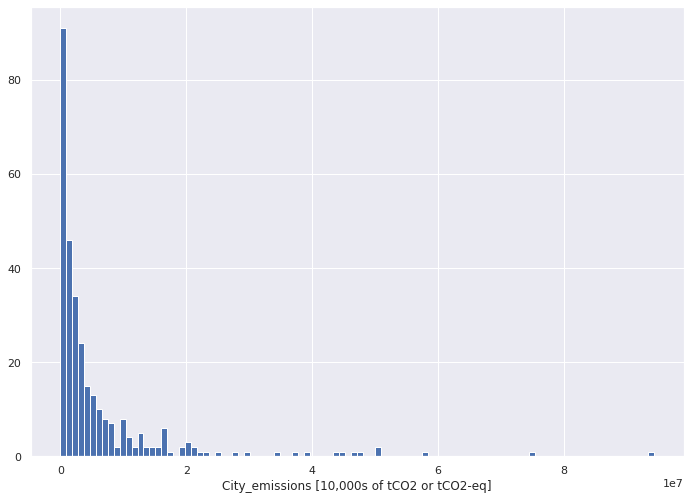

In [12]:
# Plot histogram to visualize the spread of emissions
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(df1['City_emissions [tCO2 or tCO2-eq]'], bins=100)
plt.xlabel("City_emissions [10,000s of tCO2 or tCO2-eq]")
plt.show()

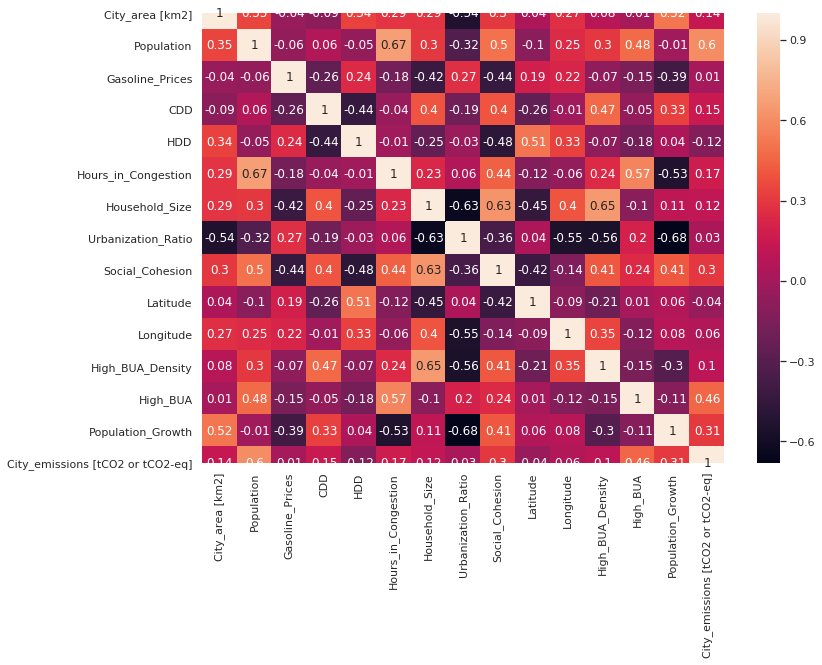

In [13]:
#Create a correlation matrix
correlation_matrix = df1.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

## Basic Data Analysis

We see from the heat map that city emissions most correlates with population and built-up area. We can visualize the correlation by plotting each feature against city emissions.

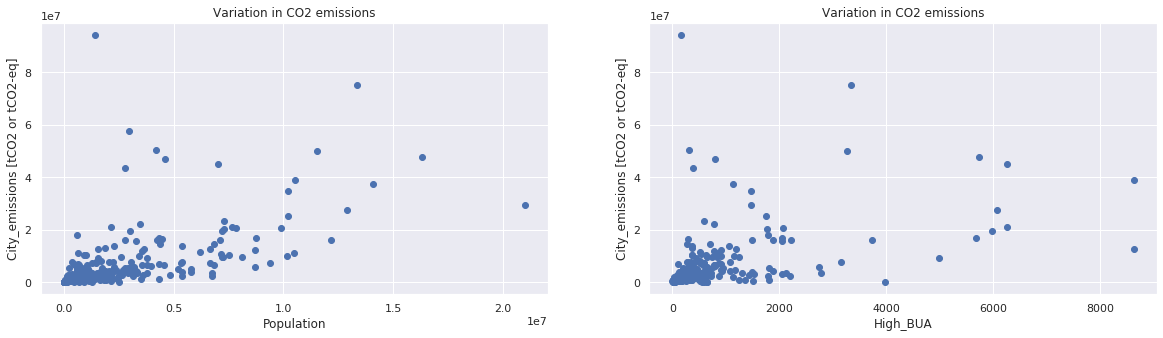

In [14]:
#Plot the selected features to view a correlation prior to standardization

plt.figure(figsize=(20,5))

features = ['Population', 'High_BUA']
target = df1['City_emissions [tCO2 or tCO2-eq]']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df1[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title("Variation in CO2 emissions")
    plt.xlabel(col)
    plt.ylabel('City_emissions [tCO2 or tCO2-eq]')

Population Model
--------------------------------------
The mean population is 2297023.61
The variance of the population data is 9316933544057.74
The standard deviation is 3052365.24


Built-up Area Model
--------------------------------------
The mean BUA is 763.80 km2
The variance of the BUA data is 1700038.42
The standard deviation is 1303.86




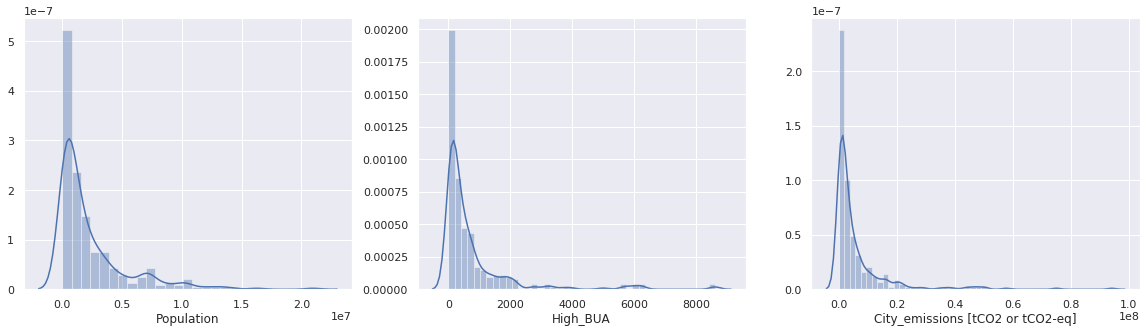

In [15]:
#Basic statistic analysis to view the mean, variance, and standard deviation
meanPop = np.mean(df1['Population'])
variancePop = np.var(df1['Population'])
stdPop = np.std(df1['Population'])

meanBUA = np.mean(df1['High_BUA'])
varianceBUA = np.var(df1['High_BUA'])
stdBUA = np.std(df1['High_BUA'])

print("Population Model")
print("--------------------------------------")
print('The mean population is {:.2f}'.format(meanPop))
print('The variance of the population data is {:.2f}'.format(variancePop))
print('The standard deviation is {:.2f}'.format(stdPop))
print("\n")

print("Built-up Area Model")
print("--------------------------------------")
print('The mean BUA is {:.2f} km2'.format(meanBUA))
print('The variance of the BUA data is {:.2f}'.format(varianceBUA))
print('The standard deviation is {:.2f}'.format(stdBUA))
print("\n")

# remove nan values from High BUA column for distplot
df2 = df1['High_BUA'].dropna(axis='rows')

# plot distribution of data
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
sns.distplot(df1['Population'], ax=axs[0])
sns.distplot(df2, ax=axs[1])
sns.distplot(df1['City_emissions [tCO2 or tCO2-eq]'], ax=axs[2])

## Data Preprocessing

From the distribution plots above, we see that our data is not standardized. According to scikitlearn' website, "[learning estimators] might behave badly if the individual features do not more or less look like standard normally distributed data". We use the Robust Scaler in the preprocessing library to reduce the effect of the outliers.

We can split our data set, then carry out standardization before implementing linear regression.

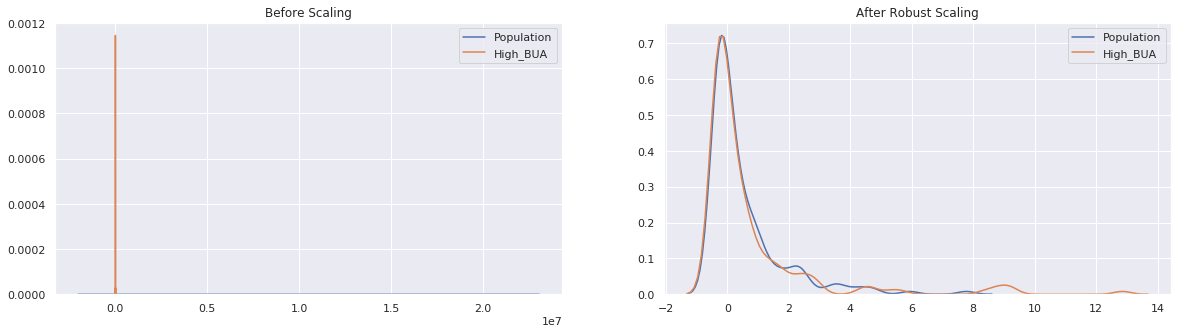

In [16]:
df2 = df1[['Population','High_BUA', 'City_emissions [tCO2 or tCO2-eq]']]
df2 = df2.dropna()

# X are all the features (independent variables), y is city emissions (dependent variable)
X = df2[['Population','High_BUA']]
y = df2['City_emissions [tCO2 or tCO2-eq]']

y = np.array(y).reshape(-1,1)

# Use sklearn's train test splitter
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)

# Use sklearn's preprocessing library to standardize data
scalerX = preprocessing.RobustScaler()
X_train_robust = scalerX.fit_transform(X_train)
X_test_robust = scalerX.transform (X_test)

scalerY = preprocessing.RobustScaler()
y_train_robust = scalerY.fit_transform(y_train)
y_test_robust = scalerY.transform (y_test)

# Make new dataframe for demonstration
robust_scaled_df = pd.DataFrame(X_train_robust, columns=['Population', 'High_BUA'])

# Make subplots 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot pre-standardized data
ax1.set_title('Before Scaling')
sns.kdeplot(df2['Population'], ax=ax1)
sns.kdeplot(df2['High_BUA'], ax=ax1)

# Plot standardized data
ax2.set_title('After Robust Scaling')
sns.kdeplot(robust_scaled_df['Population'], ax=ax2)
sns.kdeplot(robust_scaled_df['High_BUA'], ax=ax2)


Text(0.5, 1.0, 'Variation in CO2 emissions')

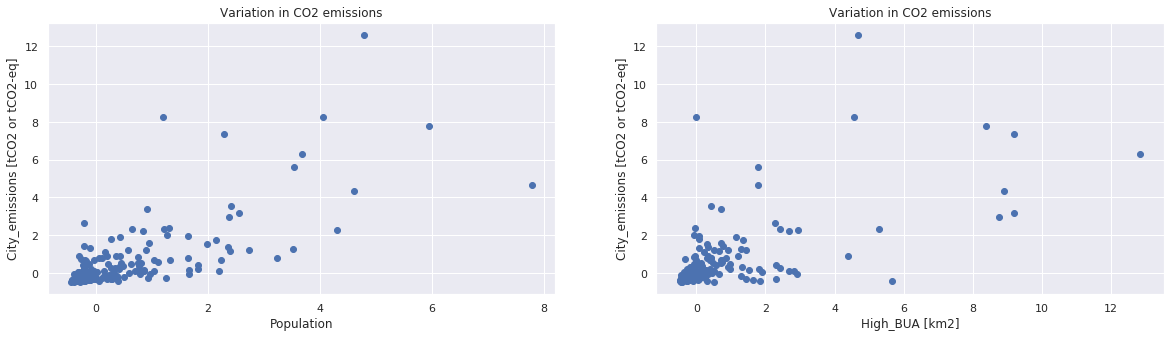

In [17]:
#Plot the selected features to view a correlation prior to standardization

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.scatter(X_train_robust[:,0],y_train_robust)
ax1.set_xlabel('Population')
ax1.set_ylabel('City_emissions [tCO2 or tCO2-eq]')
ax1.set_title('Variation in CO2 emissions')


ax2.scatter(X_train_robust[:,1],y_train_robust)
ax2.set_xlabel('High_BUA [km2]')
ax2.set_ylabel('City_emissions [tCO2 or tCO2-eq]')
ax2.set_title('Variation in CO2 emissions')



## Standard Linear Regression with Ordinary Least Squares (OLS)

We can view the results of standard linear regression, which uses Ordinary Least Squares (OLS), on our dataset. This can serve as a model for our attempt with gradient descent.

    Variables      Coef
0  Population  0.776708
1    High_BUA  0.294042


The y-intercept is: 0.015627


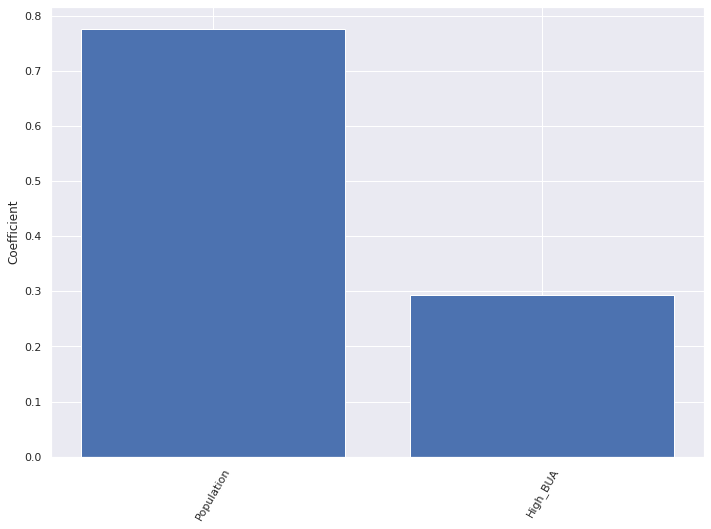

The model performance for test set
--------------------------------------
Root Mean Squared Error: 2.17972673644026
R^2: 0.142090816434565




In [18]:
#Call the sklearn linear regression method to fit training data
reg = LinearRegression().fit(X_train_robust, y_train_robust)

#Call the predict method to predict on testing data
predict = reg.predict(X_test_robust)

#Obtain the coefficients 
names = ['Population','High_BUA']
reg_coef = reg.fit(X_train_robust, y_train_robust).coef_
reg_intercept = reg.fit(X_train_robust, y_train_robust).intercept_
reg_coef = reg_coef[0]

coef_df = pd.DataFrame(names, columns = ['Variables'])
coef_df['Coef'] = reg_coef

#Basic data analysis to view how well the OLS method is at predicting
#The results are more likely a limitation of available data points
rmse = np.sqrt(mean_squared_error(y_test_robust, predict))
r2 = r2_score(y_test_robust, predict)

#Configuration for display 
print(coef_df)
print('\n')
print("The y-intercept is: {:.6f}".format(reg_intercept[0]))

plt.bar(range(len(names)),reg_coef)
plt.xticks(range(len(names)),names, rotation = 60)
plt.ylabel('Coefficient')
plt.show()

print("The model performance for test set")
print("--------------------------------------")
print("Root Mean Squared Error: {}".format(rmse))
print("R^2: {}".format(r2))
print("\n")

## Linear Regression with Stochastic Gradient Descent

We can also use an unaltered version of the stochastic gradient descent method to show a possible result and help us understand the process better. 

We realize that it gives a roughly similar answer.

    Variables      Coef
0  Population  0.840564
1    High_BUA  0.279277


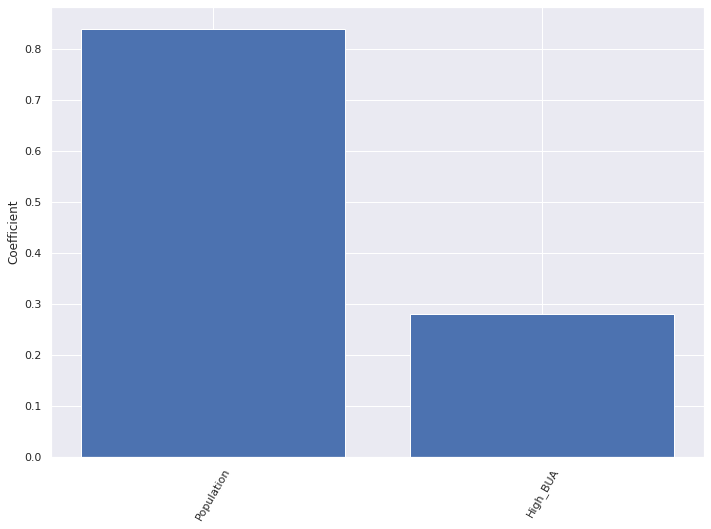

CPU times: user 226 ms, sys: 4.07 ms, total: 231 ms
Wall time: 227 ms


In [19]:
%%time
n_epochs = 50  # number of iterations
t0, t1 = 5, 50  # learning schedule hyperparameters
m = X_train_robust.shape[0] # use the len of the data points array

# define a learning schedule to decrease the learning rate over time
def learning_schedule(t):
    return t0 / (t + t1)

# random initialization
theta = np.random.randn(2,1)  

# for each iteration 
for epoch in range(n_epochs):
    # for each value in the array
    for i in range(m):

        # pick a random index within range of data size
        random_index = np.random.randint(m)

        # select the data point at that index
        xi = X_train_robust[random_index:random_index+1]
        yi = y_train_robust[random_index:random_index+1]

        # calculate the gradient of the loss function 
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)

        # update the learning rate (decrease it)
        eta = learning_schedule(epoch * m + i)

        # update the theta (weight) value
        theta = theta - eta * gradients

        
# configuration for displaying data 
grad_theta = np.zeros(reg_coef.shape)
grad_theta[0] = theta[0]
grad_theta[1] = theta[1]

coef_df = pd.DataFrame(names, columns = ['Variables'])
coef_df['Coef'] = grad_theta

print(coef_df)

plt.bar(range(len(names)),grad_theta)
plt.xticks(range(len(names)),names, rotation = 60)
plt.ylabel('Coefficient')
plt.show()

## Modified Gradient Descent Method

Having applied the OLS method and having dissected the stochastic gradient descent method, we can now attempt modifications to the gradient descent method to obtain a new model 

Here are some key points to note about the gradient descent method used above:

* The learning rate follows a rational function model, we can modify the learning rate to model a dampening sine wave. This would aid in escaping any local minima. However, since it is a linear regression problem, there is only one global minima. Hence, this is not very relevant

* This is a single-agent implementation, where only one path is taken to arrive at a gradient. We can actually instantiate multiple agents and 

Text(0.5, 1.0, 'Learning Schedule')

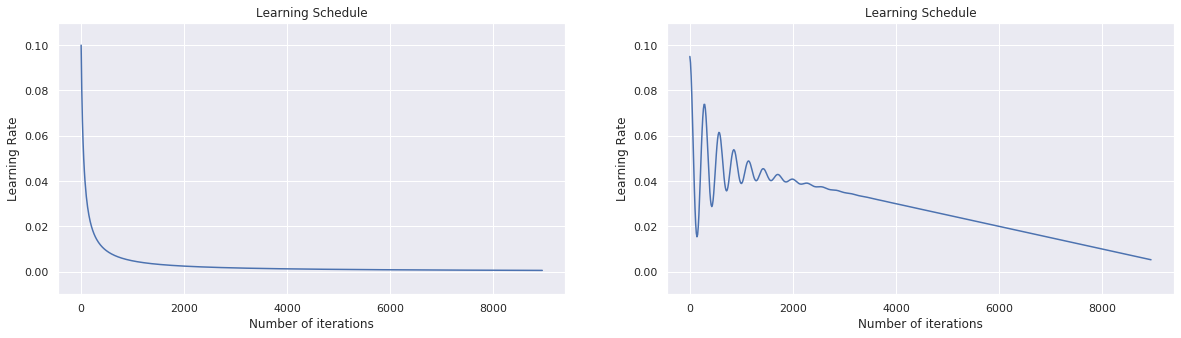

In [20]:
#Parameters for new learning rate
amp = 0.045
lam = 2e-3
omega = 0.48
lin = 5e-6

#Function for new learning rate
def damp_sin(t):
    return amp*np.exp(-lam*t)*np.cos(omega*t)+0.05-lin*t


#Make linspace using the total number of iterations 
lr_demo_x = np.linspace(0, n_epochs*m, num=m*4, endpoint=True)

#Obtain learning rate values for both learning schedules
lr_demo_y_old = learning_schedule(lr_demo_x)
lr_demo_y_new = damp_sin(lr_demo_x)


# Configuration for display
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.plot(lr_demo_x,lr_demo_y_old)
ax1.set_ylim([-0.01, 0.11])
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel("Learning Rate")
ax1.set_title("Learning Schedule")

ax2.plot(lr_demo_x,lr_demo_y_new)
ax2.set_ylim([-0.01, 0.11])
ax2.set_xlabel("Number of iterations")
ax2.set_ylabel("Learning Rate")
ax2.set_title("Learning Schedule")


    Variables      Coef
0  Population  0.761535
1    High_BUA  0.280733


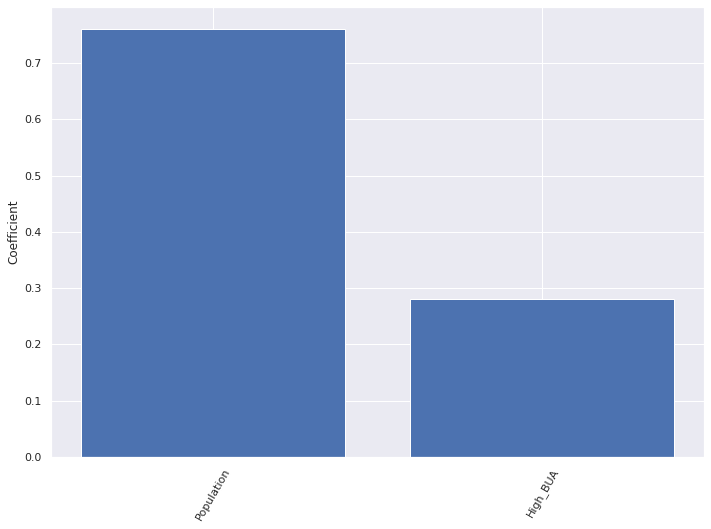

CPU times: user 486 ms, sys: 7.68 ms, total: 494 ms
Wall time: 493 ms


In [21]:
%%time

#Parameters for new learning rate
n_epochs = 50  # number of iterations
amp = 0.045
lam = 2e-3
omega = 0.48
lin = 5e-6

m = X_train_robust.shape[0] # use the len of the data points array

#Function for new learning rate
def damp_sin(t):
    return amp*np.exp(-lam*t)*np.cos(omega*t)+0.05-lin*t

    theta = np.random.randn(2,1)  # random initialization

# for each iteration 
for epoch in range(n_epochs):

    # for each value in the array
    for i in range(m):

        temp = np.zeros((3,2))
        
        for j in range(3):
            
            # select three random points
            random_index = np.random.randint(j*m/3, high=((j+1)*m)/3)
            
            xi = X_train_robust[random_index:random_index+1]

            yi = y_train_robust[random_index:random_index+1]

            # calculate gradients of each of the three points
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi)

            temp[j][0] = gradients[0]
            temp[j][1] = gradients[1]
        
        # find the average gradient from the three points
        avg_grad = np.mean(temp, axis=0)
        avg_grad = avg_grad.reshape(-1,1)

        # update the learning rate (decrease it)
        eta = learning_schedule(epoch * m + i)

        # update the theta (weight) value
        theta = theta - eta * avg_grad


# configuration for displaying data 
grad_theta = np.zeros(reg_coef.shape)
grad_theta[0] = theta[0]
grad_theta[1] = theta[1]

coef_df = pd.DataFrame(names, columns = ['Variables'])
coef_df['Coef'] = grad_theta

print(coef_df)

plt.bar(range(len(names)),grad_theta)
plt.xticks(range(len(names)),names, rotation = 60)
plt.ylabel('Coefficient')
plt.show()